# KNN benchmark

This notebook repeats the KNN benchmark reported in Smith et al.

In [1]:
from collections import OrderedDict
import os
from pathlib import Path
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from utilities import hdf_keys

In [2]:
DATA_PATH = Path("/data/pfizer_tx")

Benchmark classification tasks only

In [3]:
classification_strings = ['stage', 'grade', 'GSE']
all_classification_files = [f for f in os.listdir(DATA_PATH/"tasks_all_clr")\
                            if any([e in f for e in classification_strings])]

Work up a cross-validated classifier on a trial dataset: `all_clr_train_LUAD_stage.h5`

In [4]:
all_classification_files[0]

'all_clr_train_LUAD_stage.h5'

In [5]:
test_data_path = DATA_PATH/"tasks_all_clr"/all_classification_files[0]
keys = hdf_keys(test_data_path)
print(keys)
test_data = {key : pd.read_hdf(test_data_path, key = key) for key in keys}

['/expression', '/labels']


In [6]:
def inner_func(input_x, input_y):
    inner = KFold(n_splits=5)
    k = [1, 3, 5, 7, 9] # matches the search used in the original paper
    best_params = None
    best_auc = 0.5
    for idx, (t, v) in enumerate(inner.split(input_x)):
        this_knn = KNN(n_neighbors=k[idx], n_jobs=-1)
        x_train, y_train = input_x.iloc[t], input_y.iloc[t]
        x_valid, y_valid = input_x.iloc[v], input_y.iloc[v]
        print(f"Fitting model with k: {k[idx]}")
        fitted_model = this_knn.fit(x_train, y_train)
        valid_prob = fitted_model.predict_proba(x_valid)
        valid_auc = roc_auc_score(y_true=y_valid, y_score=valid_prob[:,1])
        if valid_auc > best_auc:
            best_auc = valid_auc
            best_k = k[idx]
        # finally train on all the data and predict held out sample
    print(f"Best K: {best_k}, training final model")
    this_knn = KNN(n_neighbors=best_k, n_jobs=-1)
    fitted_model = this_knn.fit(input_x, input_y)
    return fitted_model

Now train the outer loop

In [8]:
start = time()
outer = KFold(n_splits=5); performance = []; best_k = []
for idx, (t, v) in enumerate(outer.split(test_data["/expression"])):
    print(f"Fold {idx+1}")
    x_train, y_train = test_data["/expression"].iloc[t], test_data["/labels"].iloc[t]
    x_test, y_test = test_data["/expression"].iloc[v], test_data["/labels"].iloc[v]
    this_model_outer = inner_func(x_train, y_train)
    y_test_prob = this_model_outer.predict_proba(x_test)
    performance.append(roc_auc_score(y_true=y_test, y_score=y_test_prob[:,1]))
    best_k.append(this_model_outer.get_params()['n_neighbors'])
time_taken = time() - start

Fold 1
Fitting model with k: 1
Fitting model with k: 3
Fitting model with k: 5
Fitting model with k: 7
Fitting model with k: 9
Best K: 5, training final model
Fold 2
Fitting model with k: 1
Fitting model with k: 3
Fitting model with k: 5
Fitting model with k: 7
Fitting model with k: 9
Best K: 3, training final model
Fold 3
Fitting model with k: 1
Fitting model with k: 3
Fitting model with k: 5
Fitting model with k: 7
Fitting model with k: 9
Best K: 7, training final model
Fold 4
Fitting model with k: 1
Fitting model with k: 3
Fitting model with k: 5
Fitting model with k: 7
Fitting model with k: 9
Best K: 7, training final model
Fold 5
Fitting model with k: 1
Fitting model with k: 3
Fitting model with k: 5
Fitting model with k: 7
Fitting model with k: 9
Best K: 5, training final model


In [9]:
print(f"Entire nested CV took {time_taken} s to train")

Entire nested CV took 69.22485709190369 s to train


In [10]:
[print(e) for e in zip(best_k, performance)];

(5, 0.5322853279242732)
(3, 0.5372448979591836)
(7, 0.6451054998270495)
(7, 0.5305197070108126)
(5, 0.5551470588235294)


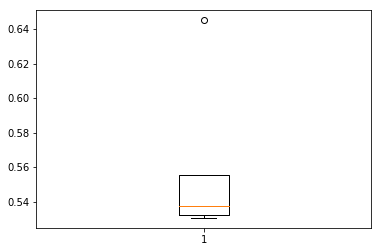

In [11]:
plt.boxplot(performance);

In [12]:
print(f"Final average model performance: {np.mean(performance)}")
print(f"Reported performance: {0.587241122}")

Final average model performance: 0.5600604983089696
Reported performance: 0.587241122


Now try and turn this into a Class

In [83]:
class NestedCV:
    def __init__(self, model, hparams, n_splits_outer=5):
        """Nested cross validation class.
        
        Parameters
        ----------
        model : func
                Must be a function which takes a single parameter - a dict containing its hyperparameters
                It must return a trainable model with an skl API
        hparams : dict
                A dict containing all the hyperparameters to be tried
        n_splits_outer : int
                The number of splits in the outer loop
                        
        """
        self.model = model
        self.hparams = hparams
        self.n_splits_outer=5
        self.n_splits_inner = np.prod([len(hparams[k]) for k in hparams])
        print(f"Number of inner splits (product of all hparam values): {self.n_splits_inner}")
        
    def _inner_loop(self, input_x, input_y):
        inner = KFold(n_splits=self.n_splits_inner)
        params = ParameterGrid(self.hparams)
        best_k = None
        best_auc = 0.5
        for idx, (t, v) in enumerate(inner.split(input_x)):
            this_model = self.model(params[idx])
            x_train, y_train = input_x.iloc[t], input_y.iloc[t]
            x_valid, y_valid = input_x.iloc[v], input_y.iloc[v]
            print(f"Fitting model with params: {params[idx]}")
            fitted_model = this_model.fit(x_train, y_train)
            valid_prob = fitted_model.predict_proba(x_valid)
            valid_auc = roc_auc_score(y_true=y_valid, y_score=valid_prob[:,1])
            if valid_auc > best_auc:
                best_auc = valid_auc
                best_k = k[idx]
            # finally train on all the data and predict held out sample
        print(f"Best params: {best_params}, training final model")
        this_model = self.model(best_params)
        fitted_model = this_model.fit(input_x, input_y)
        return fitted_model
    
    def _outer_loop(self, X, Y):
        start = time()
        outer = KFold(n_splits=self.n_splits_outer)
        performance = []
        best_params = []
        for idx, (t, v) in enumerate(outer.split(X)):
            print(f"Fold {idx+1}")
            x_train, y_train = X.iloc[t], Y.iloc[t]
            x_test, y_test = X.iloc[v], Y.iloc[v]
            this_model_outer = self._inner_loop(x_train, y_train)
            y_test_prob = this_model_outer.predict_proba(x_test)
            performance.append(roc_auc_score(y_true=y_test, y_score=y_test_prob[:,1]))
            best_params.append(this_model_outer.get_params())
        time_taken = time() - start
        return(performance, best_params, time_taken)
    
    def train(self, X, Y):
        performance, best_params, time_taken = self._outer_loop(X, Y)
        print(f"Total time taken: {time_taken}")
        print(f"Mean performance across {n_splits_outer} outer splits: {np.mean(performance)}")
        return performance, best_params
    

In [84]:
hparams = dict()
hparams['k'] = [1, 2, 3, 4, 5]

def model(params):
    return KNN(n_neighbors=params['k'], n_jobs=-1)

nestedCV = NestedCV(model, hparams)

nestedCV.train(test_data['/expression'], test_data['/labels'])